# Разработка стратегии взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист»

Цель проекта:  
Провести анализ и подготовить план действий по удержанию клиентов сети фитнес-центров «Культурист-датасаентист»  
Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
проанализировать основные признаки, наиболее сильно влияющие на отток;  
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.

## Шаг 1. Загрузка данныx

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings

warnings.filterwarnings("ignore")

Загрузим данные и посмотрим 5 произвольных строк

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.sample(5, random_state=42)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
555,1,1,0,0,1,6,1,37,205.631751,5.0,2,1.400690,1.614663,0
3491,0,0,0,0,1,6,0,27,137.370917,6.0,24,0.918920,1.093414,0
527,1,1,0,0,1,1,1,25,41.607768,1.0,1,2.893104,2.813602,0
3925,1,0,0,0,1,1,0,31,9.593524,1.0,14,2.131718,2.147013,0
2989,1,1,0,0,0,1,0,30,275.271537,1.0,4,1.653789,1.738444,0


Приведем наименование во всех столбцах к нижнему регистру

In [3]:
data.columns = data.columns.str.lower()
data.sample(5, random_state=42)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
555,1,1,0,0,1,6,1,37,205.631751,5.0,2,1.400690,1.614663,0
3491,0,0,0,0,1,6,0,27,137.370917,6.0,24,0.918920,1.093414,0
527,1,1,0,0,1,1,1,25,41.607768,1.0,1,2.893104,2.813602,0
3925,1,0,0,0,1,1,0,31,9.593524,1.0,14,2.131718,2.147013,0
2989,1,1,0,0,0,1,0,30,275.271537,1.0,4,1.653789,1.738444,0


Посмотрим общую информацию

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Проверим дубликаты

In [5]:
data.duplicated().sum()

0

В данных нет пропусков и явных дубликатов.  
Для удобства наименование всех столбцов было переведено к нижнему регистру

## Шаг 2. Исследовательский анализ данных (EDA)

Посмотрим на датасет: изучим средние значения и стандартные отклонения

In [6]:
data.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


По предоставленным данным можно оценить, что:  
Соотношение клиентов-мужчин и клиентов-женщин практически равное.  
Средний возраст - 29 лет.  
Больша часть клиентов проживает или работает в районе, где находится фитнес-центр.  
Половина клиентов посещает не более 1-2 занятий в неделю. И предпочитает НЕ групповые тренировки.
Только четверть клиентов оформляет абонементы на срок более 6 месяцев.  
Почти половины посетителей приорела абонемент по скидочной программе, действующей для сотрудников компаний-партнёров клуба.

Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [7]:
data.groupby(['churn']).mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Доля "оставшихся" чаще проживает/работает в одном районе с фитнес-центром.
А так же среди них больше клиентов, которые воспользовались скидками при оформлении абонемента (по программам от компании-партнера и акции "приведи друга").  
Ушедшие в отток в среднем чуть моложе, реже занимаются и предпочитают самостоятельные занятия групповым. Так же они в среднем чуть меньше тратят на доп.фитнес-услуги. И их "опыт" посещения зала - меньше месяца.

Можно предположить, что наименьшим образом на отток влюят признаки пола (gender) и наличия телефона в анкете(phone).  
Наиболее заметное - длительность и срок окончания действующего абонемента (contract_period и month_to_end_contract). Что объяснимо желанием окупить вложенные средства.  
Так же важные критерии - наличие скидок на абонементы (partner и promo_friends), частота посещений и тип занятий.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

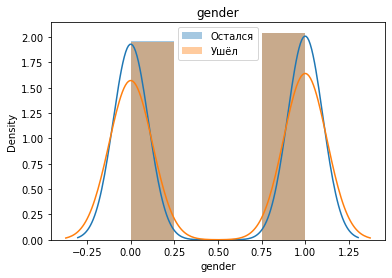

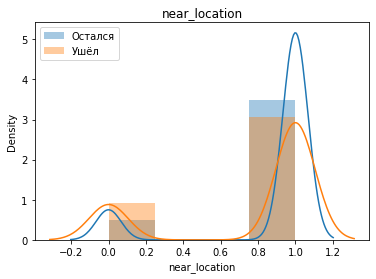

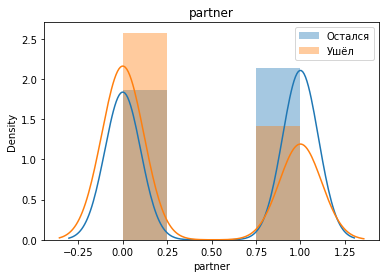

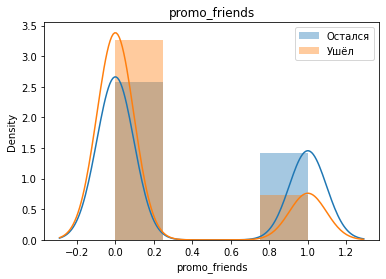

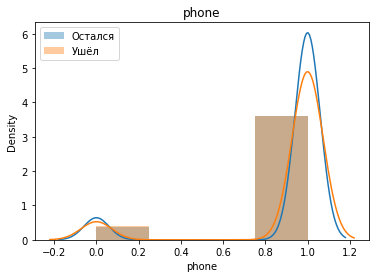

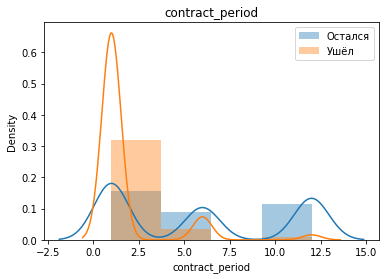

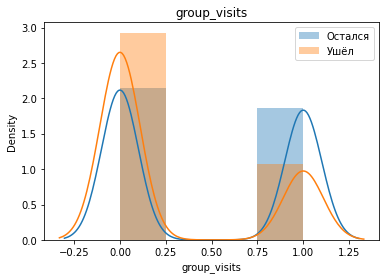

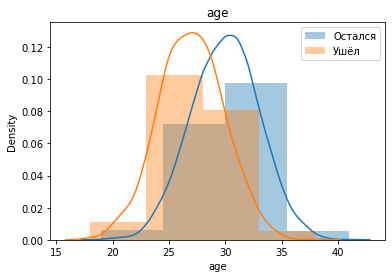

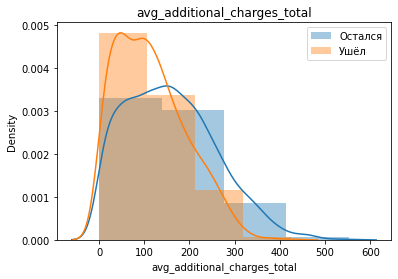

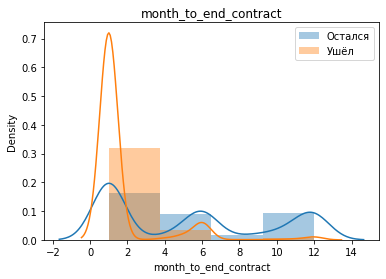

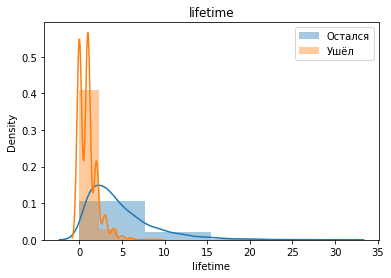

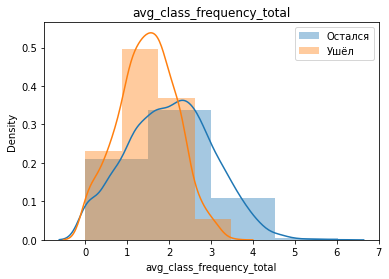

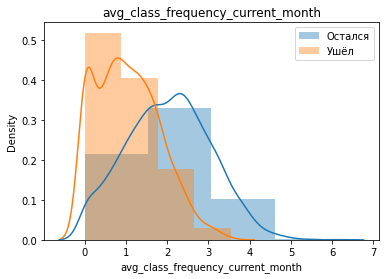

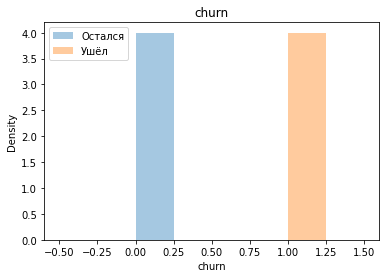

In [9]:
for feature in data.columns:
    sns.distplot(data.query('churn == 0')[feature], bins=4, label='Остался')
    sns.distplot(data.query('churn == 1')[feature], bins=4, label='Ушёл')
    plt.title(feature)
    plt.legend()
    plt.show()  

Построим матрицу корреляций и отобразим её.

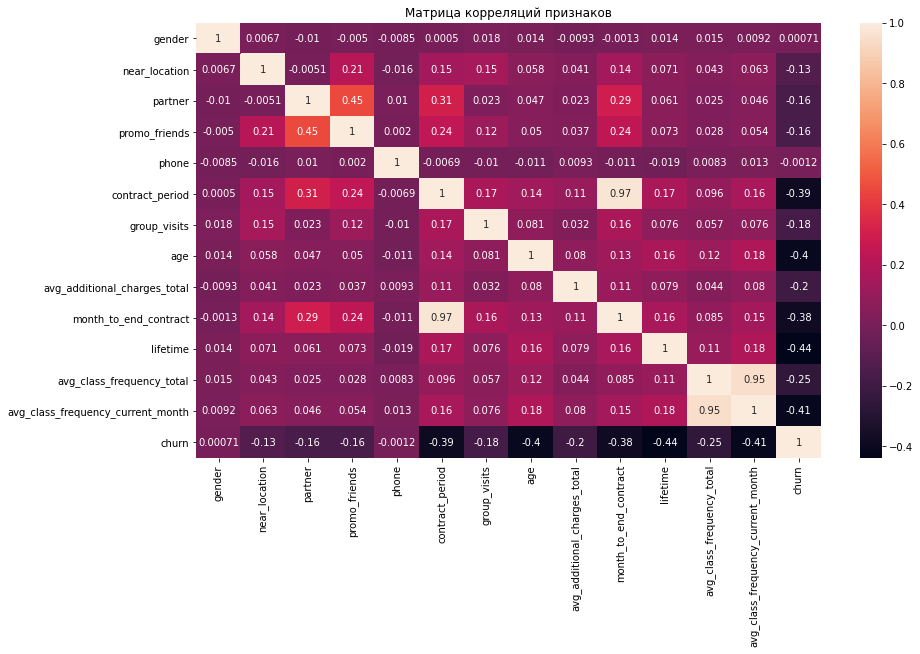

In [10]:
corr = data.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot = True, square=False)
plt.title('Матрица корреляций признаков')
plt.show()

Наименьшая корреляция с целевой переменной, как и предполагалось ранее, у признаков (gender) и (phone).  
Наибольшая корреляция у признаков (lifetime), (avg_class_frequency_current_month), (age) и (contract_period).  
Можно предположить мультиколлинеарные признаки - (contract_period) и (month_to_end_contract),  (avg_class_frequency_current_month) и (avg_class_frequency_total)

## Шаг 3. Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.  
Разделим данные на набор значений признаков и целевую переменную.

In [11]:
X = data.drop(['churn'], axis = 1)
y = data['churn']

Разобьём данные на обучающую и валидационную выборку функцией train_test_split().

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)

Обучим модель на train-выборке логистической регрессией.

In [13]:
lr_model = LogisticRegression(solver='liblinear', random_state = 0) # зададим алгоритм для первой модели
lr_model.fit(X_train, y_train) # обучим модель
lr_predictions = lr_model.predict(X_test) # бинарный прогноз
lr_probabilities = lr_model.predict_proba(X_test)

Обучим модель на train-выборке методом случайный лес.

In [14]:
rf_model = RandomForestClassifier(random_state = 0) # зададим алгоритм для первой модели
rf_model.fit(X_train, y_train) # обучим модель
rf_predictions = rf_model.predict(X_test) # бинарный прогноз
rf_probabilities = rf_model.predict_proba(X_test)

Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [15]:
# выведем метрики для полученного прогноза методом логистической регрессии
display('Способ логистической регрессии')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

# выведем метрики для полученного прогноза методом случайный лес
display('Способ Случайный лес')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

'Способ логистической регрессии'

'Accuracy: 0.93'

'Precision: 0.89'

'Recall: 0.84'

'Способ Случайный лес'

'Accuracy: 0.92'

'Precision: 0.88'

'Recall: 0.83'

Обе модели по метрике вероятности предсказания оттока показали высокий результат более 90%.  
Результаты на валидационной выборке сопоставимы, чуть лучше у способа логистической регрессии. 

## Шаг 4. Кластеризация клиентов

Проведём кластеризацию объектов (клиентов). Для начала стандартизируем данные.

In [16]:
scaler = StandardScaler() # создадим объект класса scaler
scaler.fit(X) # обучаем стандартизвтор 
X_sc = scaler.transform(X) # преобразуем набор данных

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

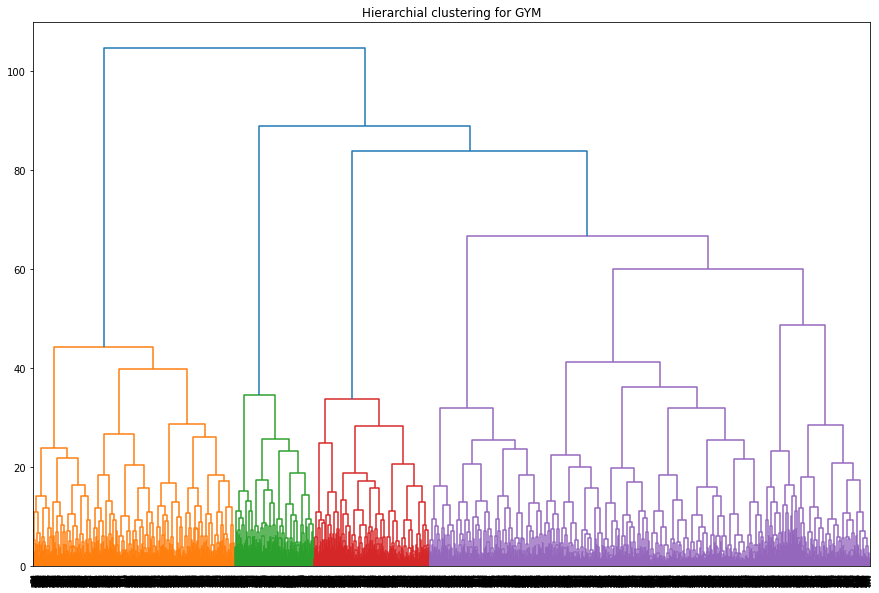

In [17]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

По полученной дендограмме можно выделить от 4 до 6 кластеров. Возьмём для расчёта среднее значение - 5.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [18]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

Посмотрим на средние значения признаков для кластеров.

In [19]:
data['cluster_km'] = labels # сохраняем метки кластера в поле нашего датасета
display(data.groupby('cluster_km').mean().T) # выводим статистику по средним значениям наших признаков по кластеру

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Самый высокий средний показатель оттока в группах 2 и 3.
Клиенты из этих групп реже посещают групповые занятия. Меньше тратят на дополнительные услуги. 
Реже других групп пользовались скидкой при покупке абонемента и чаще выбирают более короткий срок его действия.

Построим распределения признаков для кластеров.

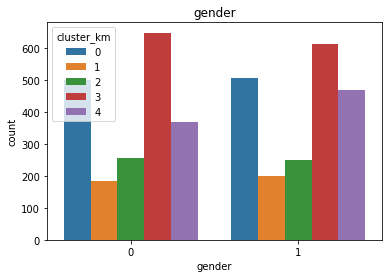

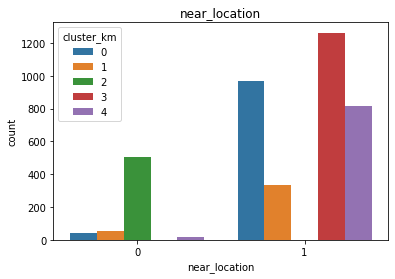

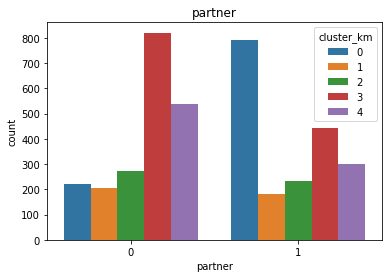

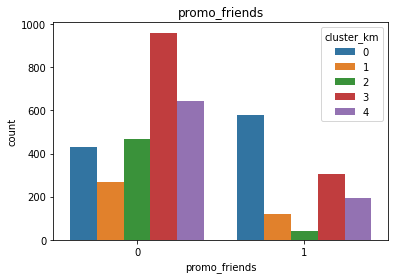

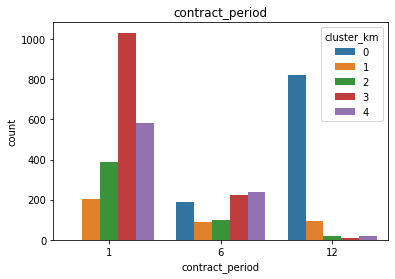

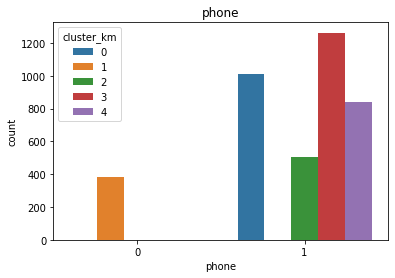

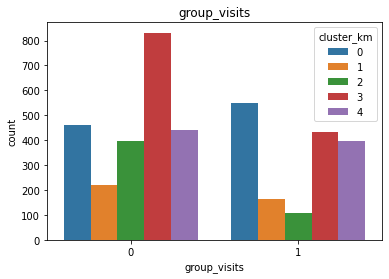

In [20]:
for feature in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period', 'phone', 'group_visits']:
    sns.countplot(x = data[feature], hue='cluster_km', data = data)
    plt.title(feature)
    plt.show()

Признак (near_location) характерен в группах 0, 1, 3 и 4. Для группы 2 - наоборот: клиенты не живут/работают в одном районе с клубом.    
Призник (partner) Для группы 3 и 4 большинство клиентов пришли не по партнёрской программе, тогда как в 0 - таких клиентов большинство.  
Признак (promo_friends) Только у 0 кластера кол-во пользователей по акции превышает кол-вл без акции.  
Признак (сontract_period) Для большинства клиентов с 1 по 4 группый - абонемент приобретён на месяц, зато для 0 кластера характерно брать годовой абонем.  
Признак (phone) Все клиенты, не оставившие номер телефона, попали в 1 группу.  
Признак (group_visits) Значительная часть 3 кластера не ходит на групповые занятия.

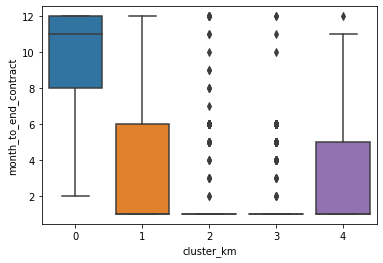

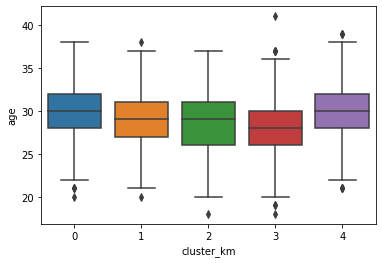

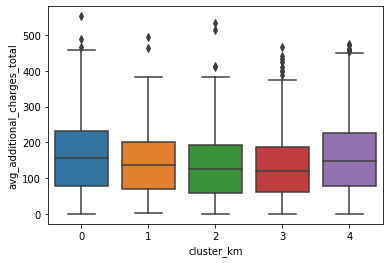

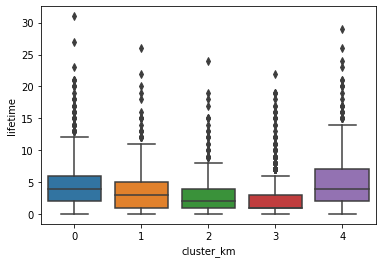

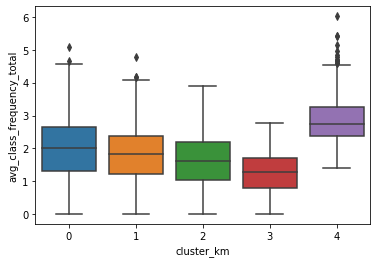

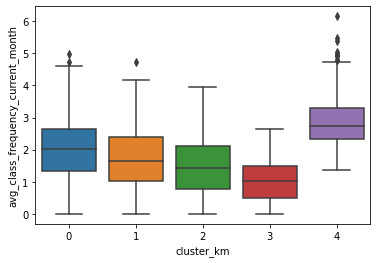

In [21]:
for features in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    sns.boxplot(x ='cluster_km', y = data[features], data = data)
    plt.show()

Признак (month_to_end_contract) Выделяется 0 группа с самым продолжительным остатком абонемента(по признаку (сontract_period) определили, что они же и покупают годовые абонементы).  
Признак (age) Распределение между группами не слишком очевидное. Можно отметить, что клиенты 0 и 4 группы чуть старше 3.  
Признак (avg_additional_charges_total) По тратами немного выделяется "старшие" 0 и 4 группы.  
Признак (lifetime) Очень много выбросов по данному показателю у всех групп. Тем не менее у 3 кластера наименьший рзброс.  
Признак (avg_class_frequency_total) и (avg_class_frequency_current_month) выделяется 4 группа с бОльшим кол-вом посещений в неделю.

Для каждого полученного кластера посчитаем долю оттока.

In [23]:
data.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

Наибольшая доля оттока приходиться на 2 и 3 кластер

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

1) По результатам исследования меньший отток можно наблюдать в группе, где клиент приобрёл абонемент на 6 месяцев/год. Необходимо стимулировать клиентов "на месяц" приобретением более продолжительного абонементы. Возможные варианты: скидка на продление по окончании срока действия текущего, варианты рассрочки для оплаты более дорогих и продолжительных абонементов.  
2) Для группы с наименьшим оттоком характерна большая доля клиентов, которые пришли, используя скидку по акции "Приведи друга". То есть по рекомендации друзей. Возможный вариант для расширения программы: пробное посещение/занятие для друга, вместо скидки.  
3) Клиенты, которые чаще попадают в отток занимаются реже. Необходимо увеличить количество посещений за период (например: месяц). Возможный вариант: бонусная система по достижению определённого количества посещений. Например: фреш или протеиновый батончик из кафе, скидка на спорттовары, массаж или чекап организма.